# 🧠 TissueGraph: Spatial Graphs for Tissue Microenvironments
This notebook demonstrates the three core features of **TissueGraph**, a tool for analyzing spatial cell organization from multiplexed imaging data (e.g., MIBI, CODEX).

**Features covered:**
1. Super-node graph construction based on DBSCAN clustering
2. Cell-level participation graphs
3. Barycentric plots relative to spatial neighborhoods

In [1]:
# 📦 Imports
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.spatial import distance_matrix
from skimage.io import imread
from skimage.measure import regionprops
from matplotlib import tri as mtri

## 🔹 Step 1: Load Data
You can load either a CSV file with cell coordinates or a segmentation mask.

In [3]:
# Option 1: From segmentation mask
def load_centroids_from_mask(mask_path):
    mask = imread(mask_path)
    props = regionprops(mask)
    return pd.DataFrame([{
        'Cell_ID': p.label,
        'X': p.centroid[1],
        'Y': p.centroid[0]
    } for p in props])

df = load_centroids_from_mask("path_to_segmentation_mask") #substitute with path to your segmentation masks

# Option 2: From CSV
def load_centroids_from_csv(csv_path):
    return pd.read_csv(csv_path)

df = load_centroids_from_csv("example_cells.csv") #substitute with path to your own csv file if available

## 🔹 Step 2: Super-node Graph from Cell Neighborhoods

_You can modify the `eps` and `min_samples` parameters in DBSCAN to adjust how neighborhoods are detected._

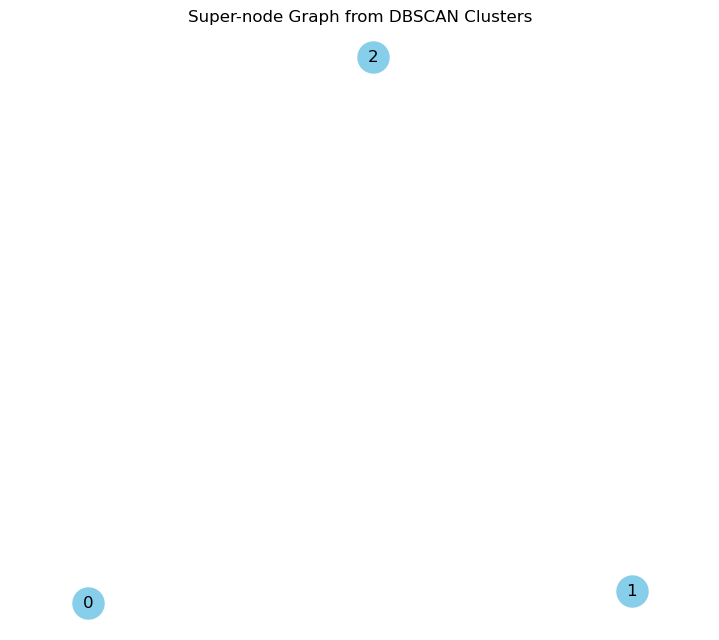

In [9]:
# 📤 Save and show Super-node Graph
def build_supernode_graph(df, eps=30, min_samples=5):
    coords = df[['X','Y']].values
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    df['neighborhood'] = clustering.labels_
    centers = df[df.neighborhood >= 0].groupby('neighborhood')[['X','Y']].mean()
    G = nx.Graph()
    for nid, row in centers.iterrows():
        G.add_node(nid, pos=(row.X, row.Y))
    dm = distance_matrix(centers.values, centers.values)
    for i, a in enumerate(centers.index):
        for j, b in enumerate(centers.index):
            if i < j and dm[i, j] < eps * 2:
                G.add_edge(a, b)
    return G, df

G, df = build_supernode_graph(df)

# Plot Super-node Graph
plt.figure(figsize=(7, 6))
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500)
plt.title("Super-node Graph from DBSCAN Clusters")
plt.axis('equal')
plt.savefig("supernode_graph.png")
plt.show()


## 🔹 Step 3: Participation Graph (Cell-Level)

_You can adjust the `radius` parameter to change how many neighboring cells are considered when computing participation._

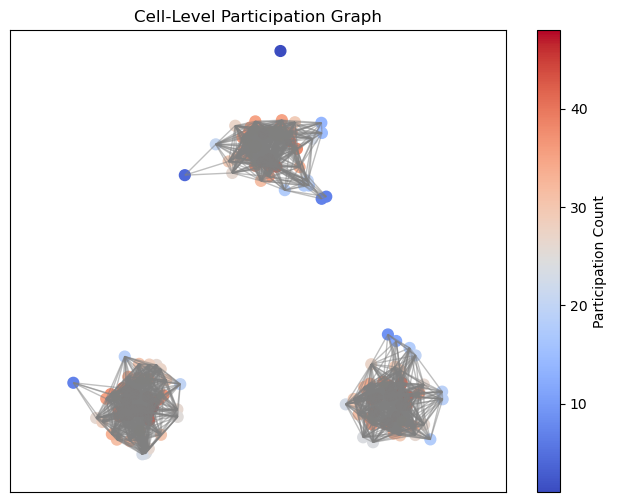

In [17]:
# 📤 Save and show Participation Graph
def build_participation_graph(df, radius=20):
    coords = df[['X','Y']].values
    dm = distance_matrix(coords, coords)
    neighborhoods = [set(np.where(dm[i] <= radius)[0]) for i in range(len(coords))]
    participation = np.zeros(len(coords), dtype=int)
    for nb in neighborhoods:
        for idx in nb:
            participation[idx] += 1
    df['participation'] = participation
    G = nx.Graph()
    for i, row in df.iterrows():
        G.add_node(row.Cell_ID, pos=(row.X, row.Y), p=participation[i])
    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            if dm[i, j] <= radius:
                G.add_edge(df.loc[i, 'Cell_ID'], df.loc[j, 'Cell_ID'])
    return G, df
    
# Rebuild graph and df with participation info
G, df = build_participation_graph(df, radius=20)

# Plot Participation Graph
plt.figure(figsize=(8, 6))
pos = nx.get_node_attributes(G, 'pos')
colors = [df[df['Cell_ID'] == n]['participation'].values[0] for n in G.nodes()]
# Use scatter to create a proper colorbar
x = [pos[n][0] for n in G.nodes()]
y = [pos[n][1] for n in G.nodes()]
scatter = plt.scatter(x, y, c=colors, cmap='coolwarm', s=60)
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)
plt.title("Cell-Level Participation Graph")
plt.colorbar(scatter, label="Participation Count")
plt.axis('equal')
plt.savefig("cell_participation_graph.png")
plt.show()


## 🔹 Step 4: Barycentric Plots Relative to Neighborhoods

_This plot uses triangulation of neighborhood centers. It gives a spatial overview of how cells are embedded relative to local structures._

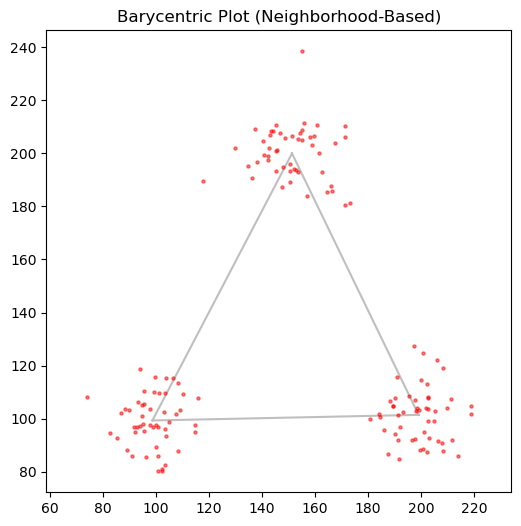

In [26]:
def plot_barycentric(df):
    centers = df[df.neighborhood >= 0].groupby('neighborhood')[['X','Y']].mean().values
    tri = mtri.Triangulation(centers[:,0], centers[:,1])
    plt.figure(figsize=(6,6))
    plt.triplot(tri, color='gray', alpha=0.5)
    plt.scatter(df.X, df.Y, s=5, c='red', alpha=0.5)
    plt.title('Barycentric Plot (Neighborhood-Based)')
    plt.axis('equal')
    plt.savefig("barycentric_plot.png")
    plt.show()

plot_barycentric(df)